# Sequential Recommendation using PTGCN
> Building a sequential movie recommender on movielens-1m data using a newly-proposed graph based recommender model in pytorch

- toc: true
- badges: true
- comments: true
- categories: [Graph, Movie, Sequential, PyTorch]
- image:

## Setup

In [ ]:
import os
import math
import time
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader

## Data Layer

In [ ]:
def data_partition(fname):
    
    # read ratings
    ratings = []
    with open(fname) as f:
        for l in f:
            user_id, item_id, rating, timestamp = [int(_) for _ in l.split('::')]
            ratings.append({
                    'user_id': user_id,
                    'item_id': item_id,
                    'rating': rating,
                    'timestamp': timestamp,
                    })
    ratings = pd.DataFrame(ratings)

    ratings['timestamp'] = ratings['timestamp'] - min(ratings['timestamp'])   

    users = ratings['user_id'].unique()
    items = ratings['item_id'].unique()

    user_ids_invmap = {id_: i for i, id_ in enumerate(users)}
    item_ids_invmap = {id_: i for i, id_ in enumerate(items)}
    ratings['user_id'].replace(user_ids_invmap, inplace=True)
    ratings['item_id'].replace(item_ids_invmap, inplace=True)

    print('user_count:'+str(len(users))+','+'item_count:'+str(len(items)))
    print('avr of user:'+str(ratings['user_id'].value_counts().mean())+'avr of item:'+str(ratings['item_id'].value_counts().mean()))
    print(len(ratings))

    users = ratings['user_id'].unique()
    items = ratings['item_id'].unique()
    
    ratings = ratings.sort_values(by='timestamp',ascending=True)  
    ratings = ratings.reset_index(drop=True)
    full_data = []
    
    adj_user = {cur_user:ratings[ratings.user_id == cur_user].index.tolist() for cur_user in users} 
    adj_item = {cur_item:ratings[ratings.item_id == cur_item].index.tolist() for cur_item in items}
    
    for i in range(ratings.shape[0]):  #edge ID
        
        cur_user = ratings['user_id'].iloc[i]
        cur_item = ratings['item_id'].iloc[i]
        if adj_user[cur_user].index(i)>=3 and adj_item[cur_item].index(i)>=3:
            full_data.append(i)
          
    offset1 = int(len(full_data) * 0.8)
    offset2 = int(len(full_data) * 0.9)
    random.shuffle(full_data)
    train_data, valid_data, test_data = full_data[0:offset1], full_data[offset1:offset2], full_data[offset2:len(full_data)]
   
    del ratings['rating']
    print(ratings.columns)
    
    return ratings, train_data, valid_data, test_data

In [ ]:
# download data
!wget -q https://github.com/sparsh-ai/reco-data/raw/master/ml-1m-dat/ratings.dat

# preprocessing
ratings, train_data, valid_data, test_data = data_partition("./ratings.dat")

user_count:6040,item_count:3706
avr of user:165.5975165562914avr of item:269.88909875876953
1000209
Index(['user_id', 'item_id', 'timestamp'], dtype='object')


## NeighborFinder `class`

In [ ]:
class NeighborFinder:
    def __init__(self, ratings):

        self.ratings = np.array(ratings)

        users = ratings['user_id'].unique()
        items = ratings['item_id'].unique()
        self.user_edgeidx = {cur_user: np.array(ratings[ratings.user_id == cur_user].index.tolist()) for cur_user in
                             users}
        self.item_edgeidx = {cur_item: np.array(ratings[ratings.item_id == cur_item].index.tolist()) for cur_item in
                             items}

    def get_user_neighbor(self, source_idx, timestamps, n_neighbors, device):

        assert (len(source_idx) == len(timestamps))

        adj_user = torch.zeros((len(source_idx), n_neighbors), dtype=torch.int32).to(device)
        user_mask = torch.ones((len(source_idx), n_neighbors), dtype=torch.bool).to(device)
        user_time = torch.zeros((len(source_idx), n_neighbors), dtype=torch.int32).to(
            device)  # time matirx
        adj_user_edge = torch.zeros((len(source_idx), n_neighbors), dtype=torch.int32).to(device)

        edge_idxs = torch.searchsorted(self.ratings[:, 2], timestamps)

        for i in range(len(source_idx)):
            idx = torch.searchsorted(self.user_edgeidx[source_idx[i].item()], edge_idxs[i].item()) 
            his_len = len(self.user_edgeidx[source_idx[i].item()][:idx])
            used_len = his_len if his_len <= n_neighbors else n_neighbors

            adj_user[i, n_neighbors - used_len:] = self.ratings[:, 1][
                self.user_edgeidx[source_idx[i].item()][idx - used_len:idx]]
            user_time[i, n_neighbors - used_len:] = self.ratings[:, 2][
                self.user_edgeidx[source_idx[i].item()][idx - used_len:idx]]
            user_mask[i, n_neighbors - used_len:] = 0
            adj_user_edge[i, n_neighbors - used_len:] = self.user_edgeidx[source_idx[i].item()][idx - used_len:idx]

        return adj_user, adj_user_edge, user_time, user_mask

    def get_item_neighbor(self, destination_idx, timestamps, n_neighbors, device):

        assert (len(destination_idx) == len(timestamps))

        adj_item = torch.zeros((len(destination_idx), n_neighbors), dtype=torch.int32).to(device)
        item_mask = torch.ones((len(destination_idx), n_neighbors), dtype=torch.bool).to(device)
        item_time = torch.zeros((len(destination_idx), n_neighbors), dtype=torch.int32).to(device)
        adj_item_edge = torch.zeros((len(destination_idx), n_neighbors), dtype=torch.int32).to(device)

        edge_idxs = torch.searchsorted(self.ratings[:, 2], timestamps)

        for i in range(len(destination_idx)):
            idx = torch.searchsorted(self.item_edgeidx[destination_idx[i].item()], edge_idxs[i].item())
            his_len = len(self.item_edgeidx[destination_idx[i].item()][:idx])
            used_len = his_len if his_len <= n_neighbors else n_neighbors

            adj_item[i, n_neighbors - used_len:] = self.ratings[:, 0][
                self.item_edgeidx[destination_idx[i].item()][idx - used_len:idx]]
            item_time[i, n_neighbors - used_len:] = self.ratings[:, 2][
                self.item_edgeidx[destination_idx[i].item()][idx - used_len:idx]]
            item_mask[i, n_neighbors - used_len:] = 0
            adj_item_edge[i, n_neighbors - used_len:] = self.item_edgeidx[destination_idx[i].item()][idx - used_len:idx]

        return adj_item, adj_item_edge, item_time, item_mask

    def get_user_neighbor_ind(self, source_idx, edge_idx, n_neighbors, device):

        adj_user = np.zeros((len(edge_idx), n_neighbors), dtype=np.int32)
        user_mask = np.ones((len(edge_idx), n_neighbors), dtype=np.bool)
        user_time = np.zeros((len(edge_idx), n_neighbors), dtype=np.int32)  # time matirx
        adj_user_edge = np.zeros((len(source_idx), n_neighbors), dtype=np.int32)

        for i in range(len(edge_idx)):
            idx = np.searchsorted(self.user_edgeidx[source_idx[i]], edge_idx[i]) + 1
            his_len = len(self.user_edgeidx[source_idx[i]][:idx])
            used_len = his_len if his_len <= n_neighbors else n_neighbors

            adj_user[i, n_neighbors - used_len:] = self.ratings[:,1][self.user_edgeidx[source_idx[i]][idx - used_len:idx]]
            user_time[i, n_neighbors - used_len:] = self.ratings[:,2][self.user_edgeidx[source_idx[i]][idx - used_len:idx]]
            user_mask[i, n_neighbors - used_len:] = 0
            adj_user_edge[i, n_neighbors - used_len:] = self.user_edgeidx[source_idx[i]][idx - used_len:idx]

        return torch.from_numpy(adj_user).to(device), torch.from_numpy(adj_user_edge).to(device), torch.from_numpy(
            user_time).to(device), torch.from_numpy(user_mask).to(device)

    def get_item_neighbor_ind(self, destination_idx, edge_idx, n_neighbors, device):

        adj_item = np.zeros((len(destination_idx), n_neighbors), dtype=np.int32)
        item_mask = np.ones((len(destination_idx), n_neighbors), dtype=np.bool)
        item_time = np.zeros((len(destination_idx), n_neighbors), dtype=np.int32)
        adj_item_edge = np.zeros((len(destination_idx), n_neighbors), dtype=np.int32)

        for i in range(len(destination_idx)):
            idx = np.searchsorted(self.item_edgeidx[destination_idx[i]], edge_idx[i]) + 1
            his_len = len(self.item_edgeidx[destination_idx[i]][:idx])
            used_len = his_len if his_len <= n_neighbors else n_neighbors

            adj_item[i, n_neighbors - used_len:] = self.ratings[:,0][self.item_edgeidx[destination_idx[i]][idx - used_len:idx]]
            item_time[i, n_neighbors - used_len:] = self.ratings[:,2][self.item_edgeidx[destination_idx[i]][idx - used_len:idx]]
            item_mask[i, n_neighbors - used_len:] = 0
            adj_item_edge[i, n_neighbors - used_len:] = self.item_edgeidx[destination_idx[i]][idx - used_len:idx]

        return torch.from_numpy(adj_item).to(device), torch.from_numpy(adj_item_edge).to(device), torch.from_numpy(
            item_time).to(device), torch.from_numpy(item_mask).to(device)

## Embedding Layer

The embedding layer’s goal is to map a given input to a low-dimensional vector representation. To model sequential patterns and temporal influence of interactions effectively, we encode user index, item index, interaction time, and the absolute position of each interaction in user neighborhood (or item neighborhood) into a shared latent space. In particular, we use user neighborhood to update the user embedding and item neighborhood to update the item embedding. Finally, we perform an add operation on them to obtain the hidden representation of each interaction.

### TimeEncode `class`

Temporal information is essential to analyze individual interaction behaviors. Because the sequential recommendation task is timing-dependent, it is difficult to learn a proper embedding directly from the continuous-time nature of interactions using embedding concatenation or addition. PTGCN employs a generic time encoding method proposed by [Xu et al.](https://arxiv.org/abs/2002.07962) to embed temporal information into a vector representation. Specifically, they defined a continuous functional $\phi(∙)$ to map time intervals from the time domain to a 𝑑-dimensional vector space. For each interaction $i_{u_i,v_j,t}$, we can obtain the time embedding (𝐭) of time point 𝑡. Then, for each interaction, we utilize the user neighborhood of user $𝑢_𝑖$ at time point 𝑡 to obtain a new vector $𝐮_{𝑖,𝑡}$ and the item neighborhood of item $𝑣_𝑗$ to obtain a new vector $𝐯_{𝑗,𝑡}$ at 𝑡. In particular, we leverage the time interval between two consecutive interactions and time point 𝑡 to model the influence of historical interactions on the current state of $𝑢_𝑖$; also, this is similar to $𝑣_𝑗$.

In [ ]:
class TimeEncode(torch.nn.Module):
  # Time Encoding proposed by TGAT
  def __init__(self, dimension):
    super(TimeEncode, self).__init__()

    self.dimension = dimension
    self.w = torch.nn.Linear(1, dimension)

    self.w.weight = torch.nn.Parameter((torch.from_numpy(1 / 10 ** np.linspace(0, 9, dimension)))
                                       .float().reshape(dimension, -1))
    self.w.bias = torch.nn.Parameter(torch.zeros(dimension).float())

  def forward(self, t):
    # t has shape [batch_size, seq_len]
    # Add dimension at the end to apply linear layer --> [batch_size, seq_len, 1]
    t = t.unsqueeze(dim=1).unsqueeze(dim=2)

    # output has shape [batch_size, seq_len, dimension]
    t = t.float()
    output = torch.cos(self.w(t))

    return output

### PositionalEncoding `class`

To model sequential patterns effectively, we attempt to encode the position information of each interaction in the user neighborhood or item neighborhood. PTGCN employs the positional encoding approach proposed by [Vaswani et al.](https://arxiv.org/abs/1706.03762), which does not introduce additional parameters and can extrapolate to sequence lengths longer than pre-defined fixed ones. The positional encodings have the same dimension as the position embedding. As mentioned above, we select the latest 𝑛 neighbors before time point 𝑡 in a user-item interaction graph to constitute the user neighborhood and item neighborhood. PTGCN then learns and updates the user and item embeddings at 𝑡 according to the user neighborhood and item neighborhood. In this way, for each interaction $i_{u_i,v_j,t}$, we can obtain the corresponding position embedding $p_{i,t} \in \mathbb{R}^d$ of $u_i$ or $v_j$.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Positional Encoding class
    """
    def __init__(self, dim_model, max_length=2000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, dim_model, requires_grad=False)
        position = torch.arange(0, max_length).unsqueeze(1).float()
        exp_term = torch.exp(torch.arange(0, dim_model, 2).float() * -(math.log(10000.0) / dim_model))
        pe[:, 0::2] = torch.sin(position * exp_term) # take the odd (jump by 2)
        pe[:, 1::2] = torch.cos(position * exp_term) # take the even (jump by 2)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, maxlen):
        """
        args:
            input: B x T x D
        output:
            tensor: B x T
        """
        return self.pe[:, :maxlen]

## Supporting Modules

### MergeLayer `class`

In [ ]:
class MergeLayer(torch.nn.Module):
  def __init__(self, dim1, dim2, dim3, dim4):
    super().__init__()
    self.fc1 = torch.nn.Linear(dim1 + dim2, dim3)
    self.fc2 = torch.nn.Linear(dim3, dim4)
    self.act = torch.nn.ReLU()

    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)

  def forward(self, x1, x2):
    x = torch.cat([x1, x2], dim=1)
    h = self.act(self.fc1(x))
    return self.fc2(h)

### ScaledDotProductAttention `class`

In [ ]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):

        attn = torch.matmul(q / self.temperature, k.transpose(2, 3))

        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1))
        output = torch.matmul(attn, v)

        return output, attn

### MultiHeadAttention `class`

In [ ]:
class MultiHeadAttention(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_ks = nn.Linear(d_model, n_head * d_k, bias=False)
        self.w_vs = nn.Linear(d_model, n_head * d_v, bias=False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias=False)

        self.attention = ScaledDotProductAttention(temperature=d_k ** 0.5)

        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model, eps=1e-6)


    def forward(self, q, k, v, mask=None):

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        sz_b, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1)

        residual = q

        # Pass through the pre-attention projection: b x lq x (n*dv)
        # Separate different heads: b x lq x n x dv
        q = self.w_qs(q).view(sz_b, len_q, n_head, d_k)
        k = self.w_ks(k).view(sz_b, len_k, n_head, d_k)
        v = self.w_vs(v).view(sz_b, len_v, n_head, d_v)

        # Transpose for attention dot product: b x n x lq x dv
        q, k, v = q.transpose(1, 2), k.transpose(1, 2), v.transpose(1, 2)

        if mask is not None:
            mask = mask.unsqueeze(1)   # For head axis broadcasting.

        q, attn = self.attention(q, k, v, mask=mask)

        q = q.transpose(1, 2).contiguous().view(sz_b, len_q, -1)
        q = self.dropout(self.fc(q))
        q += residual

        q = self.layer_norm(q)

        return q, attn

### PositionwiseFeedForward `class`

In [ ]:
class PositionwiseFeedForward(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid, dropout=0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid) # position-wise
        self.w_2 = nn.Linear(d_hid, d_in) # position-wise
        self.layer_norm = nn.LayerNorm(d_in, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        residual = x

        x = self.w_2(F.relu(self.w_1(x)))
        x = self.dropout(x)
        x += residual

        x = self.layer_norm(x)

        return x

### TemporalAttentionLayer `class`

In [ ]:
class TemporalAttentionLayer(nn.Module):
  """
  Temporal attention layer. Return the temporal embedding of a node given the node itself,
   its neighbors and the edge timestamps.
  """

  def __init__(self, n_node_features, n_neighbors_features, time_dim,
               output_dimension, n_head, n_neighbor,
               dropout=0.1):
    super(TemporalAttentionLayer, self).__init__()

    self.n_head = n_head

    self.feat_dim = n_node_features
    self.time_dim = time_dim

    self.query_dim = n_node_features
    self.key_dim = n_neighbors_features
    
    self.positional_encoding = PositionalEncoding(self.feat_dim, n_neighbor+1)

    self.merger = MergeLayer(self.query_dim, n_node_features, n_node_features, output_dimension)

    self.self_attentions = nn.MultiheadAttention(embed_dim=self.query_dim,
                          kdim=self.key_dim,
                          vdim=self.key_dim,
                          num_heads=8,
                          dropout=dropout)

    self.multi_head_target = nn.MultiheadAttention(embed_dim=self.query_dim,
                                                   kdim=self.key_dim,
                                                   vdim=self.key_dim,
                                                   num_heads=n_head,
                                                   dropout=dropout)

  def forward(self, src_node_features, src_time_features, neighbors_features,
              neighbors_time_features, neighbors_padding_mask):
    
    src_node_features_unrolled = torch.unsqueeze(src_node_features, dim=1)
    
    positions = self.positional_encoding(neighbors_features.size(1)+1).repeat(src_node_features.size(0),1,1) #邻居的位置

    query = src_node_features_unrolled + src_time_features + positions[:,-1,:].unsqueeze(1)
    key = neighbors_features  + neighbors_time_features + positions[:,:-1,:]
    query = query.permute([1, 0, 2])  # [1, batch_size, num_of_features]
    key = key.permute([1, 0, 2])  # [n_neighbors, batch_size, num_of_features]

    # Compute mask of which source nodes have no valid neighbors
    invalid_neighborhood_mask = neighbors_padding_mask.all(dim=1, keepdim=True)
    neighbors_padding_mask[invalid_neighborhood_mask.squeeze(), 0] = False
    
    #enc_output = self.layer_norm(key)

    enc_output, _ = self.self_attentions(key, key, key, key_padding_mask=neighbors_padding_mask)
    key = enc_output
    
    attn_output, attn_output_weights = self.multi_head_target(query=query, key=key, value=key,
                                                              key_padding_mask=neighbors_padding_mask)

    attn_output = attn_output.squeeze()
    attn_output_weights = attn_output_weights.squeeze()

    attn_output = attn_output.masked_fill(invalid_neighborhood_mask, 0)
    attn_output_weights = attn_output_weights.masked_fill(invalid_neighborhood_mask, 0)

    # Skip connection with temporal attention over neighborhood and the features of the node itself
    attn_output = self.merger(attn_output, src_node_features)

    return attn_output, attn_output_weights

## PTGCN Model

*PTGCN models the sequential patterns and temporal dynamics between user-item interactions by defining a position-enhanced and time-aware graph convolution operation and learning the dynamic representations of users and items simultaneously on the bipartite graph with a self-attention aggregator. Also, it realizes the high-order connectivity between users and items by stacking multi-layer graph convolutions.*

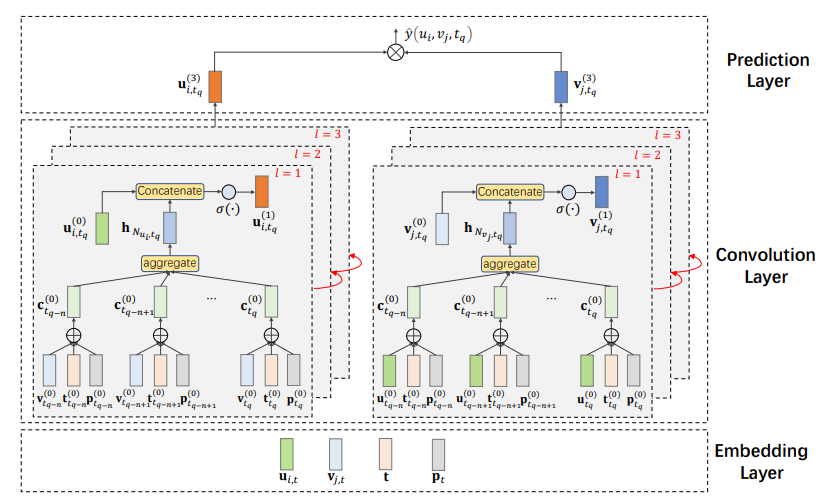

In [ ]:
class PTGCN(nn.Module):
    '''
    Position enhanced and Time aware graph convolution
    '''
    def __init__(self, user_neig50, item_neig50, num_users, num_items, time_encoder, n_layers, n_neighbors,
               n_node_features, n_time_features, embedding_dimension, device,
               n_heads=2, dropout=0.1):
        super(PTGCN, self).__init__()
    
        self.num_users = num_users
        self.num_items = num_items
        self.time_encoder = time_encoder
        self.n_layers = n_layers
        self.n_time_features = n_time_features
        self.dropout = dropout
        self.embedding_dimension = embedding_dimension
        self.device = device
        self.n_neighbors = n_neighbors
    
        self.user_embeddings = nn.Embedding(self.num_users, self.embedding_dimension)
        self.item_embeddings = nn.Embedding(self.num_items, self.embedding_dimension)
        nn.init.normal_(self.user_embeddings.weight, std=0.1)
        nn.init.normal_(self.item_embeddings.weight, std=0.1)
        
        self.user_neig50, self.user_egdes50, self.user_neig_time50, self.user_neig_mask50 = user_neig50
        self.item_neig50, self.item_egdes50, self.item_neig_time50, self.item_neig_mask50 = item_neig50
    
        self.attention_models = torch.nn.ModuleList([TemporalAttentionLayer(
            n_node_features=n_node_features,
            n_neighbors_features=n_node_features,
            time_dim=n_time_features,
            output_dimension=embedding_dimension,   
            n_head=n_heads,
            n_neighbor= self.n_neighbors[i],
            dropout=dropout)
            for i in range(n_layers)])

    def compute_embedding(self, nodes, edges, timestamps, n_layers, nodetype='user'):
        """
        src_idx_l [batch_size]: users / items input ids.
        cut_time_l [batch_size]: scalar representing the instant of the time where we want to extract the user / item representation.
        curr_layers [scalar]: number of temporal convolutional layers to stack.
        num_neighbors [scalar]: number of temporal neighbor to consider in each convolutional layer.
        """
        assert (n_layers >= 0)
        n_neighbor = self.n_neighbors[n_layers-1]
        nodes_torch = nodes.long()
        edges_torch = edges.long()
        timestamps_torch = timestamps.long()

        # query node always has the start time -> time span == 0
        nodes_time_embedding = self.time_encoder(torch.zeros_like(timestamps_torch))
        if nodetype=='user':
            node_features = self.user_embeddings(nodes_torch)
        else:
            node_features = self.item_embeddings(nodes_torch)
            
        if n_layers == 0:
            return node_features
        else:
            if nodetype=='user':
                
                adj, adge, times, mask = self.user_neig50[edges_torch,-n_neighbor:], self.user_egdes50[edges_torch,-n_neighbor:], self.user_neig_time50[edges_torch,-n_neighbor:], self.user_neig_mask50[edges_torch,-n_neighbor:]
                
                edge_deltas = timestamps_torch.unsqueeze(1) - times   #[batch_size,n_neighors]
                adj = adj.flatten()
                times = times.flatten()
                adge = adge.flatten()

                neighbor_embeddings = self.compute_embedding(adj, adge, times, n_layers - 1, 'item')
                neighbor_embeddings = neighbor_embeddings.view(len(nodes), n_neighbor, -1)
                edge_time_embeddings = self.time_encoder(edge_deltas.flatten())
                edge_time_embeddings = edge_time_embeddings.view(len(nodes), n_neighbor, -1)

                node_embedding,_  = self.attention_models[n_layers - 1](node_features,
                                        nodes_time_embedding,
                                        neighbor_embeddings,
                                        edge_time_embeddings,
                                        mask)
            
        
            if nodetype=='item':
                adj, adge, times, mask = self.item_neig50[edges_torch,-n_neighbor:], self.item_egdes50[edges_torch,-n_neighbor:], self.item_neig_time50[edges_torch,-n_neighbor:], self.item_neig_mask50[edges_torch,-n_neighbor:]
                
                edge_deltas = timestamps_torch.unsqueeze(1) - times   #[batch_size,n_neighors]
                adj = adj.flatten()
                times = times.flatten()
                adge = adge.flatten()
                
                neighbor_embeddings = self.compute_embedding(adj, adge, times, n_layers - 1, 'user')
                neighbor_embeddings = neighbor_embeddings.view(len(nodes), n_neighbor, -1)
                edge_time_embeddings = self.time_encoder(edge_deltas.flatten())
                edge_time_embeddings = edge_time_embeddings.view(len(nodes), n_neighbor, -1)

                node_embedding,_ = self.attention_models[n_layers - 1](node_features,
                                        nodes_time_embedding,
                                        neighbor_embeddings,
                                        edge_time_embeddings,
                                        mask)
            
        
        return node_embedding
    
    
    def forward(self, nodes, edges, timestamps, n_layers, nodetype='user'):
        
        return self.compute_embedding(nodes, edges, timestamps, n_layers, nodetype)

## Configuration

In [ ]:
class Config(object):
    """config."""
    data = 'Moivelens'
    batch_size = 64
    n_degree = [20,50]  #'Number of neighbors to sample'
    n_head = 4  #'Number of heads used in attention layer'
    n_epoch = 1 #'Number of epochs'
    n_layer = 1 #'Number of network layers'
    lr = 0.0001  #'Learning rate'
    patience = 15  #'Patience for early stopping'
    drop_out = 0.1  #'Dropout probability'
    gpu = 0,  #'Idx for the gpu to use'
    node_dim = 160  #'Dimensions of the node embedding'
    time_dim = 160  #'Dimensions of the time embedding'
    embed_dim = 160 #'Dimensions of the hidden embedding'
    is_GPU = True
    temperature = 0.07

## Evaluation method

In [ ]:
def evaluate(model, ratings, items, dl, adj_user_edge, adj_item_edge, adj_user_time, adj_item_time, device):

    torch.cuda.empty_cache()
    NDCG5 = 0.0
    NDCG10 = 0.0
    recall5 = 0.0
    recall10 =0.0
    num_sample = 0
    
    with torch.no_grad():
        model = model.eval()
        
        for ix,batch in enumerate(dl):
            if ix%100==0:
                print('batch:',ix)
            count = len(batch)
            num_sample = num_sample + count
            b_user_edge = find_latest_1D(np.array(ratings.iloc[batch]['user_id']), adj_user_edge, adj_user_time, ratings.iloc[batch]['timestamp'].tolist())
            b_user_edge = torch.from_numpy(b_user_edge).to(device)
            b_users = torch.from_numpy(np.array(ratings.iloc[batch]['user_id'])).to(device) 
            
            b_item_edge = find_latest_1D(np.array(ratings.iloc[batch]['item_id']), adj_item_edge, adj_item_time, ratings.iloc[batch]['timestamp'].tolist())
            b_item_edge = torch.from_numpy(b_item_edge).to(device)
            b_items = torch.from_numpy(np.array(ratings.iloc[batch]['item_id'])).to(device)
            timestamps = torch.from_numpy(np.array(ratings.iloc[batch]['timestamp'])).to(device)
            
            negative_samples = sampler(items, adj_user, ratings.iloc[batch]['user_id'].tolist() ,100)  
            neg_edge = find_latest(negative_samples, adj_item_edge, adj_item_time, ratings.iloc[batch]['timestamp'].tolist())
            negative_samples = torch.from_numpy(np.array(negative_samples)).to(device)
            item_set = torch.cat([b_items.view(-1,1),negative_samples], dim=1) #batch, 101
            timestamps_set = timestamps.unsqueeze(1).repeat(1,101)
            neg_edge = torch.from_numpy(neg_edge).to(device)
            edge_set = torch.cat([b_item_edge.view(-1,1),neg_edge], dim=1) #batch, 101
            
            user_embeddings = model(b_users, b_user_edge,timestamps, config.n_layer, nodetype='user')
            itemset_embeddings = model(item_set.flatten(), edge_set.flatten(), timestamps_set.flatten(), config.n_layer, nodetype='item')
            itemset_embeddings = itemset_embeddings.view(count, 101, -1)
            
            logits = torch.bmm(user_embeddings.unsqueeze(1), itemset_embeddings.permute(0,2,1)).squeeze() # [count,101]
            logits = -logits.cpu().numpy()
            rank = logits.argsort().argsort()[:,0]
            
            recall5 += np.array(rank<5).astype(float).sum()
            recall10 += np.array(rank<10).astype(float).sum()
            NDCG5 += (1 / np.log2(rank + 2))[rank<5].sum()
            NDCG10 += (1 / np.log2(rank + 2))[rank<10].sum()
            
        recall5 = recall5/num_sample
        recall10 = recall10/num_sample
        NDCG5 = NDCG5/num_sample
        NDCG10 = NDCG10/num_sample
            
        print("===> recall_5: {:.10f}, recall_10: {:.10f}, NDCG_5: {:.10f}, NDCG_10: {:.10f}, time:{}".format(recall5, recall10, NDCG5, NDCG10, time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))))

    return recall5, recall10, NDCG5, NDCG10

## Prepare for training

In [ ]:
def sampler(items, adj_user, b_users, size):
    negs = []
    for user in b_users:      
        houxuan = list(set(items)-set(adj_user[user]))
        src_index = random.sample(list(range(len(houxuan))), size)
        negs.append(np.array(houxuan)[src_index])
    negs = np.array(negs)
    return negs

def find_latest(nodes, adj, adj_time, timestamps):
    #negative_samples, [b,size]
    edge = np.zeros_like(nodes)
    for ix in range(nodes.shape[0]):
        for iy in range(nodes.shape[1]):
            node = nodes[ix, iy]
            edge_idx = np.searchsorted(adj_time[node], timestamps[ix])-1
            edge[ix, iy] = np.array(adj[node])[edge_idx]
    return edge

def find_latest_1D(nodes, adj, adj_time, timestamps):
    #negative_samples, [b,size]
    edge = np.zeros_like(nodes)
    for ix in range(nodes.shape[0]):
        node = nodes[ix]
        edge_idx = np.searchsorted(adj_time[node], timestamps[ix])-1
        edge[ix] = np.array(adj[node])[edge_idx]
    return edge

In [ ]:
config = Config()
checkpoint_dir='/content'  
min_NDCG10 = 1000.0
max_itrs = 0

device_string = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_string)

In [ ]:
users = ratings['user_id'].unique()
items = ratings['item_id'].unique() 
items_in_data = ratings.iloc[train_data+valid_data+test_data]['item_id'].unique()

adj_user = {user: ratings[ratings.user_id == user]['item_id'].tolist() for user in users}
adj_user_edge = {user:ratings[ratings.user_id == user].index.tolist() for user in users}
adj_user_time = {user:ratings[ratings.user_id == user]['timestamp'].tolist() for user in users} 

adj_item_edge = {item:ratings[ratings.item_id == item].index.tolist() for item in items}
adj_item_time = {item:ratings[ratings.item_id == item]['timestamp'].tolist() for item in items} 

num_users = len(users)
num_items = len(items)
neighor_finder = NeighborFinder(ratings)
time_encoder = TimeEncode(config.time_dim)
MLPLayer = MergeLayer(config.embed_dim, config.embed_dim, config.embed_dim, 1)

a_users = np.array(ratings['user_id'])
a_items = np.array(ratings['item_id'])
edge_idx = np.arange(0, len(a_users))

user_neig50 = neighor_finder.get_user_neighbor_ind(a_users, edge_idx, max(config.n_degree), device)
item_neig50 = neighor_finder.get_item_neighbor_ind(a_items, edge_idx, max(config.n_degree), device)

criterion = torch.nn.CrossEntropyLoss(reduction='sum')

model = PTGCN(user_neig50, item_neig50, num_users, num_items,
                time_encoder, config.n_layer,  config.n_degree, config.node_dim, config.time_dim,
                config.embed_dim, device, config.n_head, config.drop_out
                ).to(device)

optim = torch.optim.Adam(model.parameters(),lr=config.lr)

num_params = 0
for param in model.parameters():
    num_params += param.numel()
print(num_params)

# batch
dl = DataLoader(train_data, config.batch_size, shuffle=True, pin_memory=True)

1842880


## Training and validation

In [ ]:
#hide-output
itrs = 0
sum_loss=0
for epoch in range(config.n_epoch):
    time1 = 0.0
    x=0.0
    for id,batch in enumerate(dl):
        #print('epoch:',epoch,' batch:',id)
        x=x+1
        optim.zero_grad()
        
        count = len(batch)
        
        b_user_edge = find_latest_1D(np.array(ratings.iloc[batch]['user_id']), adj_user_edge, adj_user_time, ratings.iloc[batch]['timestamp'].tolist())
        b_user_edge = torch.from_numpy(b_user_edge).to(device)
        b_users = torch.from_numpy(np.array(ratings.iloc[batch]['user_id'])).to(device) 
        
        b_item_edge = find_latest_1D(np.array(ratings.iloc[batch]['item_id']), adj_item_edge, adj_item_time, ratings.iloc[batch]['timestamp'].tolist())
        b_item_edge = torch.from_numpy(b_item_edge).to(device)
        b_items = torch.from_numpy(np.array(ratings.iloc[batch]['item_id'])).to(device)
        timestamps = torch.from_numpy(np.array(ratings.iloc[batch]['timestamp'])).to(device)
        
        negative_samples = sampler(items_in_data, adj_user, ratings.iloc[batch]['user_id'].tolist() ,1) 
        neg_edge = find_latest(negative_samples, adj_item_edge, adj_item_time, ratings.iloc[batch]['timestamp'].tolist())
        negative_samples = torch.from_numpy(np.array(negative_samples)).to(device)
        negative_samples = negative_samples.squeeze()
        neg_edge = torch.from_numpy(neg_edge).to(device)
        neg_edge = neg_edge.squeeze()

        time0 = time.time()

        user_embeddings = model(b_users, b_user_edge, timestamps, config.n_layer, nodetype='user')
        item_embeddings = model(b_items, b_item_edge, timestamps, config.n_layer, nodetype='item')
        negs_embeddings = model(negative_samples, neg_edge, timestamps, config.n_layer, nodetype='item')
        
        with torch.no_grad():
            labels = torch.zeros(count, dtype=torch.long).to(device)
        l_pos = torch.bmm(user_embeddings.view(count, 1, -1), item_embeddings.view(count, -1, 1)).view(count, 1) # [count,1] 
        
        l_u = torch.bmm(user_embeddings.view(count, 1, -1), negs_embeddings.view(count, -1, 1)).view(count, 1) # [count,n_negs]           
        logits = torch.cat([l_pos, l_u], dim=1)  # [count, 2]
        loss = criterion(logits/config.temperature, labels)

        loss.backward()
        optim.step()
        itrs += 1
        time1 = time1 + (time.time() - time0)
        print('time:'+str(time1 / x))

        sum_loss = sum_loss + loss.item()
        avg_loss = sum_loss / itrs 
                
        if id%10==0:
            print("===>({}/{}, {}): loss: {:.10f}, avg_loss: {:.10f}, time:{}".format(id, len(dl), epoch, loss.item(), avg_loss, time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))))
            
        
    ### Validation
    if epoch%3==0:
        val_bl = DataLoader(valid_data, 5, shuffle=True, pin_memory=True)
        recall5, recall10, NDCG5, NDCG10 = evaluate(model, ratings, items, val_bl, adj_user_edge, adj_item_edge, adj_user_time, adj_item_time, device)
    
    if min_NDCG10>NDCG10:
        min_NDCG10 = NDCG10
        max_itrs = 0
    else:   
        max_itrs += 1
        if max_itrs>config.patience:
            break

## Evaluation

In [21]:
print('Epoch %d test' % epoch)
test_bl1 = DataLoader(test_data, 5, shuffle=True, pin_memory=True)
recall5, recall10, NDCG5, NDCG10 = evaluate(model, ratings, items, test_bl1, adj_user_edge, adj_item_edge, adj_user_time, adj_item_time, device)

Epoch 1 test
batch: 0
batch: 100
batch: 200
batch: 300
batch: 400
batch: 500
batch: 600
batch: 700
batch: 800
batch: 900
batch: 1000
batch: 1100
batch: 1200
batch: 1300
batch: 1400
batch: 1500
batch: 1600
batch: 1700
batch: 1800
batch: 1900
batch: 2000
batch: 2100
batch: 2200
batch: 2300
batch: 2400
batch: 2500
batch: 2600
batch: 2700
batch: 2800
batch: 2900
batch: 3000
batch: 3100
batch: 3200
batch: 3300
batch: 3400
batch: 3500
batch: 3600
batch: 3700
batch: 3800
batch: 3900
batch: 4000
batch: 4100
batch: 4200
batch: 4300
batch: 4400
batch: 4500
batch: 4600
batch: 4700
batch: 4800
batch: 4900
batch: 5000
batch: 5100
batch: 5200
batch: 5300
batch: 5400
batch: 5500
batch: 5600
batch: 5700
batch: 5800
batch: 5900
batch: 6000
batch: 6100
batch: 6200
batch: 6300
batch: 6400
batch: 6500
batch: 6600
batch: 6700
batch: 6800
batch: 6900
batch: 7000
batch: 7100
batch: 7200
batch: 7300
batch: 7400
batch: 7500
batch: 7600
batch: 7700
batch: 7800
batch: 7900
batch: 8000
batch: 8100
batch: 8200
bat

## Performance comparison

### Comparison among different methods in recommendation performance

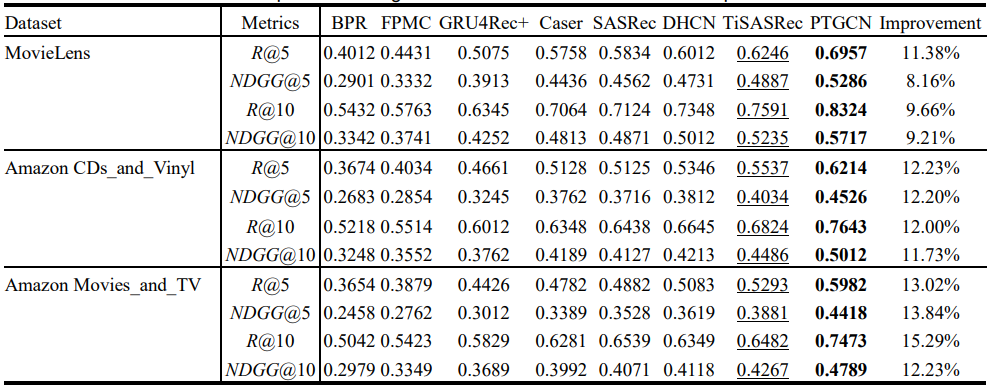

### Performance comparison over the sparsity distribution of user groups

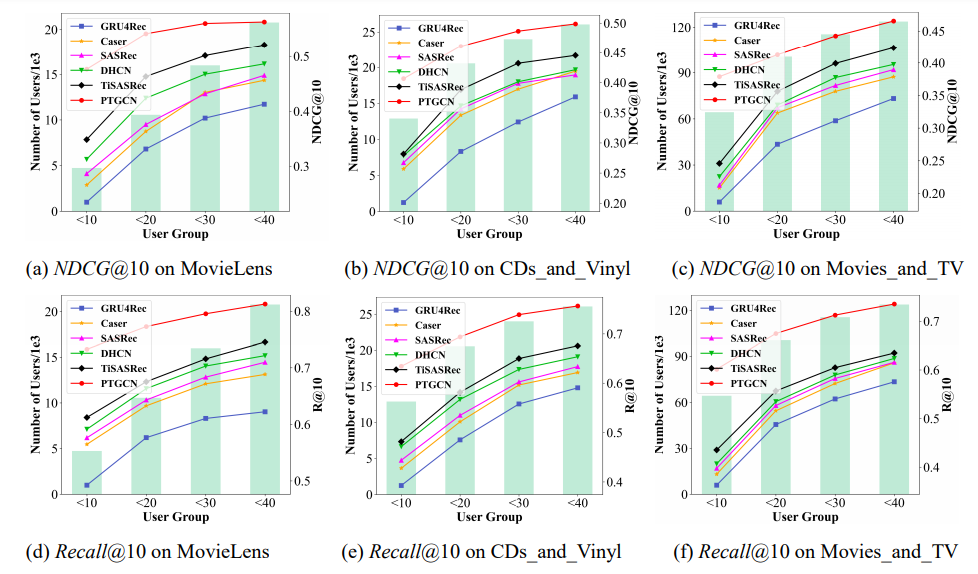

### Comparison among different methods in training efficiency

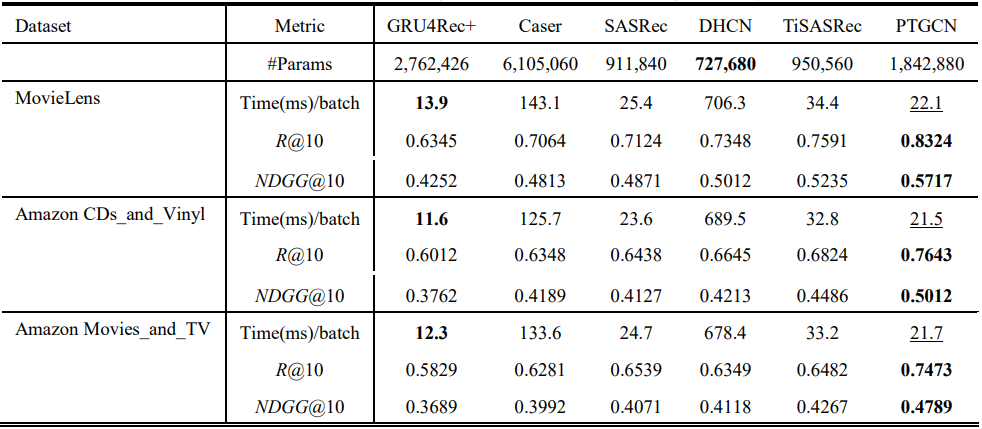